# Double-cantilever-beam: ERR calculation

Consider a DCB of length $L=1$ thickness $H=0.3 L$, with a crack of length $L_c$

1. For $L_c=0.5$:

    (a) Solve the elastic problem for imposed displacement
    
    (b) Plot the crack opening displacement in a neighborhood of the crack tip; deduce from the crack opening displacement a first estimate of the energy relase rate.
    
    (c) Plot the stress $\sigma_{\theta\theta}$ in a neighborhood of the crack tip; deduce from the stress $\sigma_{\theta\theta}$ a second estimate of the energy relase rate.
    
    (d) Calculate the energy release as a finite difference approximation of the potential energy
    
    
2. For $L\in[0.2,0.8]$:
    - Calculate the potential energy as a function of $L_c$ and obtain the corresponding finite-difference approximation of the energy release rate.
    - Plot the force-displacement diagram. 
    - Give the crack evolution law for the crack as a function of the loading for the case of applied displacement
    - Give the crack evolution law for the crack as a function of the loading for the case of applied force

In [1]:
import dolfin 
import mshr
import ufl
import matplotlib.pyplot as plt
import numpy as np
import mshr
%config Completer.use_jedi = False
%config IPCompleter.greedy = True

# Basic example

## Mesh generation

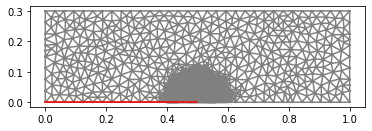

In [2]:
def generate_mesh(Lc=0.5,n_div=20,n_ref=4,R_ref=0.1,Lx=1.0,H1=0.3,H2=0.3):
    """
    Generate a polygonal mesh with:
        - Lc : crack length
        - n_div : number of divisions on the largest side
        - n_ref : number of refinements around the crack
        - r_ref : Radius for refinement around the crack
        - Lx : Length
        - H1 : Left side
        - H2 : Rigth side
    """
    p0 = dolfin.Point(0,0)
    pc = dolfin.Point(Lc,0)
    p1 = dolfin.Point(Lx,0)
    p2 = dolfin.Point(Lx,H2)
    p3 = dolfin.Point(0,H1)
    geom = mshr.Polygon([p0,pc,p1,p2,p3])
    mesh = mshr.generate_mesh(geom,n_div)
    
    for i in range(n_ref):
        cell_markers = dolfin.MeshFunction("bool", mesh, mesh.topology().dim())
        cell_markers.set_all(False)
        for cell in dolfin.cells(mesh):
            if cell.midpoint().distance(pc) < R_ref :
                cell_markers[cell] = True
        mesh = dolfin.refine(mesh, cell_markers)
    
    return mesh 

Lc = 0.5
Lx = 1.
mesh = generate_mesh(Lc=0.5,n_div=20,n_ref=5,R_ref=0.1,Lx=Lx,H1=0.3,H2=0.3)
dolfin.plot(mesh)
plt.plot([0,Lc],[0,0],"-r")

## Solve linear elasticity 

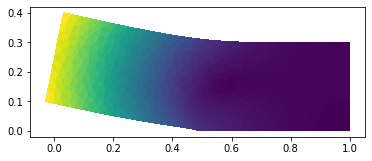

In [3]:
V = dolfin.VectorFunctionSpace(mesh, "Lagrange", 2)

# Boundary conditions
u0 = dolfin.Constant(0.0)
u1 = dolfin.Constant(1)
bc_bottom = dolfin.DirichletBC(V.sub(1), u0, f"on_boundary & near(x[1],0) && x[0] > {Lc}")
bc_left = dolfin.DirichletBC(V.sub(1), u1, "on_boundary & near(x[0],0)")
bc_right = dolfin.DirichletBC(V.sub(0), u0, f"on_boundary & near(x[0],{Lx})")
bcs = [bc_right, bc_bottom, bc_left]

# Elasticity parameters
E = dolfin.Constant(10) # Young
nu = dolfin.Constant(0.3) # Poisson
mu = E/(2*(1.0 + nu)) # lame 1 (plane-strain)
lmbda = E*nu/((1.0 + nu)*(1.0 -2.0*nu)) # lame 2 (plane-strain)

def eps(u):
    return dolfin.sym(dolfin.grad(u))

def sigma(epsilon):
    return  2*mu*epsilon + lmbda*dolfin.tr(epsilon)*dolfin.Identity(2)

# Variational formulation of the problem 

u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

# bilinear form
a = dolfin.inner(sigma(eps(u)), eps(v)) * dolfin.dx 

# linear form

# Bulk load 
bulk_load = dolfin.Constant((0.,0.))
L = dolfin.inner(bulk_load,v) * dolfin.dx

A = dolfin.assemble(a)
b = dolfin.assemble(L)
for bc in bcs:
    bc.apply(A,b)

usol = dolfin.Function(V)
dolfin.solve(A,usol.vector(),b) 

dolfin.plot(.1 * usol, mode="displacement")

## Elastic energy 

In [4]:
energy = dolfin.assemble(dolfin.inner(sigma(eps(usol)), eps(usol)) * dolfin.dx)
print(f"The elastic energy is {energy}")

The elastic energy is 0.21366174647679978


## Crack opening displacement

Estimate of the $K_I$ and the energy release rate from the crack openingg displacement 

## Crack-tip Stress

The approximate value of the SIF is $K_I=??$

## Finite differences of the energy

In [5]:
def dcb_dolver(Lc=0.5,n_div=20,n_ref=4,R_ref=0.1,Lx=1.0,H1=0.3,H2=0.3,E=10,nu=0.3):
    mesh = generate_mesh(Lc=0.5,n_div=20,n_ref=4,R_ref=0.1,Lx=1.0,H1=0.3,H2=0.3)
    V = dolfin.VectorFunctionSpace(mesh, "Lagrange", 2)
    
    # Boundary conditions
    u0 = dolfin.Constant(0.0)
    u1 = dolfin.Constant(1)
    bc_bottom = dolfin.DirichletBC(V.sub(1), u0, f"on_boundary & near(x[1],0) && x[0] > {Lc}")
    bc_left = dolfin.DirichletBC(V.sub(1), u1, "on_boundary & near(x[0],0)")
    bc_right = dolfin.DirichletBC(V.sub(0), u0, f"on_boundary & near(x[0],{Lx})")
    bcs = [bc_right, bc_bottom, bc_left]
    
    # Elasticity parameters
    mu = E/(2*(1.0 + nu)) # lame 1 (plane-strain)
    lmbda = E*nu/((1.0 + nu)*(1.0 -2.0*nu)) # lame 2 (plane-strain)
    
    def eps(u):
        return dolfin.sym(dolfin.grad(u))
    
    def sigma(epsilon):
        return  2*mu*epsilon + lmbda*dolfin.tr(epsilon)*dolfin.Identity(2)
    
    # Variational formulation of the problem 
    
    u = dolfin.TrialFunction(V)
    v = dolfin.TestFunction(V)

    # bilinear form
    a = dolfin.inner(sigma(eps(u)), eps(v)) * dolfin.dx 
    
    # linear form
    
    # Bulk load 
    bulk_load = dolfin.Constant((0.,0.))
    L = dolfin.inner(bulk_load,v) * dolfin.dx
    
    A = dolfin.assemble(a)
    b = dolfin.assemble(L)
    for bc in bcs:
        bc.apply(A,b)
    
    usol = dolfin.Function(V)
    dolfin.solve(A,usol.vector(),b) 
    energy = dolfin.assemble(dolfin.inner(sigma(eps(usol)), eps(usol)) * dolfin.dx)

    return usol, energy

